In [1]:
import os 
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
# 데이터프레임 사용 안하고,
# tf.data 통해서 하는법

In [2]:
path = 'fastcampus/dataset/cifar/train/0_frog.png'

In [3]:
gfile = tf.io.read_file(path) # 파일 읽고
image = tf.io.decode_image(gfile) # 파일 디코딩

In [4]:
image.shape # 불러온파일 모양 확인

TensorShape([32, 32, 3])

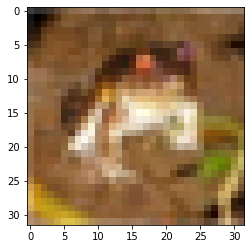

In [5]:
plt.imshow(image)
plt.show()

# tf.data

In [6]:
train_paths = glob('fastcampus/dataset/cifar/train/*.png')
train_paths[:10] # 상위 10개폴더만 표시

['fastcampus/dataset/cifar/train\\0_frog.png',
 'fastcampus/dataset/cifar/train\\10000_automobile.png',
 'fastcampus/dataset/cifar/train\\10001_frog.png',
 'fastcampus/dataset/cifar/train\\10002_frog.png',
 'fastcampus/dataset/cifar/train\\10003_ship.png',
 'fastcampus/dataset/cifar/train\\10004_ship.png',
 'fastcampus/dataset/cifar/train\\10005_cat.png',
 'fastcampus/dataset/cifar/train\\10006_deer.png',
 'fastcampus/dataset/cifar/train\\10007_frog.png',
 'fastcampus/dataset/cifar/train\\10008_airplane.png']

In [7]:
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths) # train_paths의 파일을 읽어 dataset에 저장

dataset

## train_path의 파일이 tf.string 형태로 들어갑니다.




<TensorSliceDataset shapes: (), types: tf.string>

In [10]:
# string값을 image형태로 읽을 수 있도록 해야함
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)


In [11]:
tf_image = next(iter(dataset)) ## for문으로 돌릴때 맨 처음것만 가져와봄

tf_image.shape

TensorShape([32, 32, 3])

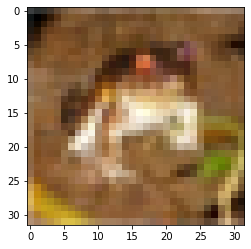

In [12]:
plt.imshow(tf_image)
plt.show()

## Batch로 묶기

In [13]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(4)

In [14]:
tf_images = next(iter(dataset))
tf_images.shape

## 배치사이즈를 4개로 한다면, next(iter)를 통해 맨처음형태를 가져왔더니 4x32x32x3이 되어있음
## 배치사이즈 설정하면 한 텐서묶음으로 전환

TensorShape([4, 32, 32, 3])

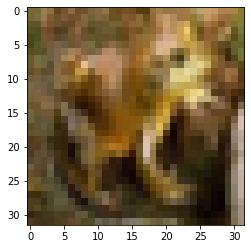

In [15]:
plt.imshow(tf_images[3])
plt.show()

## Shuffle 하기

In [16]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
# buffer size - > 가급적 데이터 갯수만큼 해주는것이 권장사항
dataset = dataset.repeat()

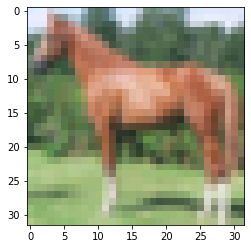

In [17]:
tf_images = next(iter(dataset))
plt.imshow(tf_images[0])
plt.show()
# 셔플하는데 시간이 조금 걸림
# 셔플된 dataset에서 0번은 개구리가 아닌 다른 랜덤한 사진이 나옴

## Label하고 같이 넣기 

In [18]:
path = train_paths[0]
path

'fastcampus/dataset/cifar/train\\0_frog.png'

In [19]:
os.path.basename(path).replace('.png', '').split('_')[-1]

'frog'

In [20]:
def get_label(path):
    return os.path.basename(path).replace('.png', '').split('_')[-1]

In [21]:
path, get_label(path)
# 파일 경로, 파일 경로에서 label확인

('fastcampus/dataset/cifar/train\\0_frog.png', 'frog')

In [22]:
train_labels = [get_label(path) for path in train_paths]
train_labels[:5]

['frog', 'automobile', 'frog', 'frog', 'ship']

In [23]:
class_names = np.unique(train_labels)
class_names
# class_names는 train 폴더내 파일명을 다 검색한 후, 유니크한 라벨만 알파벳순으로 반환
# train_labels의 종류  확인 후 알파벳순으로 정렬

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [24]:
'frog' == class_names
# 파일이 들어왔을때, 해당하는 label에 숫자를 할당하기위함

array([False, False, False, False, False, False,  True, False, False,
       False])

In [25]:
onehot_encoding = np.array('frog' == class_names, np.uint8)
onehot_encoding

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [26]:
def onehot_encoding(label):
    return np.array(label == class_names, np.uint8)

In [27]:
def load_data(path, label):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image, label

In [28]:
labels = [onehot_encoding(cls_name) for cls_name in train_labels]

# train_label은 각 train 폴더내 파일의 이름을 onehot_encoding 함수로 집어넣은 후
# class_name과 array 비교시켜 label을 array 형태로 반환

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((train_paths, labels))
dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
# 위에서 정의한 load_data를 인풋으로 넣어줌. 
#read_image를 바로넣으면 안됨.-> 인,아웃을 2개로 할당해야함.
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat() # repeat을 안해주면 epoch한번 훑고 종료해버림

In [30]:
image, label = next(iter(dataset))

In [31]:
np.array(label[0])

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [32]:
image.shape, label.shape

(TensorShape([4, 32, 32, 3]), TensorShape([4, 10]))

C:\Users\jusik\Anaconda3\envs\pytorchO\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


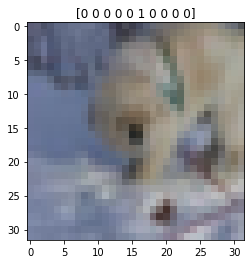

In [33]:
plt.title(np.array(label[0]))
plt.imshow(image[0])
plt.show()

## tensorflow 함수로 label 얻기



In [34]:
path

'fastcampus/dataset/cifar/train\\0_frog.png'

In [35]:
def onehot_encoding(label):
    return np.array(class_names == label, np.uint8)

In [36]:
onehot_encoding('frog')

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [37]:
fname = tf.strings.split(path, '_')[-1]
fname

<tf.Tensor: shape=(), dtype=string, numpy=b'frog.png'>

In [38]:
cls_name = tf.strings.regex_replace(fname,'.png', '')
cls_name

<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>

In [39]:
class_names


array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [40]:
class_names == cls_name #  좌변 string문자의 array, 우변 tf.string 타입

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([False, False, False, False, False, False,  True, False, False,
       False])>

In [41]:
tf.cast(class_names == cls_name, tf.uint8)

<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)>

In [42]:
def get_label(path)    :
    fname = tf.strings.split(path, '_')[-1]
    cls_name = tf.strings.regex_replace(fname,'.png', '')
    onehot_encoding = tf.cast(class_names == cls_name, tf.uint8)
    return onehot_encoding

In [43]:
def read_image_label(path):
    #read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    #get label
    label = get_label(path)
    return image, label

In [44]:
data_paths = train_paths
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image_label)
dataset = dataset.batch(4)
dataset = dataset.repeat()

In [45]:
image, label = next(iter(dataset))

In [46]:
image.shape

TensorShape([4, 32, 32, 3])

In [47]:
label[0]

<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)>

Text(0.5, 1.0, '[0 0 0 0 0 0 1 0 0 0]')

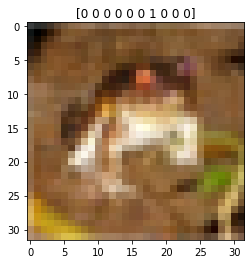

In [48]:
plt.imshow(image[0])
plt.title(np.array(label[0]))